## `chargement de la dataset`

les donnees sont issues d'une dataset de kaggle obtenu au lien suivant
https://www.kaggle.com/datasets/ishantjuyal/emotions-in-text

In [2]:
import pandas as pd

data = pd.read_csv("Emotion_final.csv", sep = ',')
data

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear


In [2]:
import numpy as np
# Affichage des intentions 
print(data.Emotion.unique())

['sadness' 'anger' 'love' 'surprise' 'fear' 'happy']


## `pretraitement`

- obtention des vecteurs de vocabulaires (codage one Hot)

In [3]:
from sklearn.feature_extraction.text import  CountVectorizer

X = data.Text
print(X)

converter = CountVectorizer(max_features=1000)

# on realise la conversion
text_one_hot = converter.fit_transform(X)
X = text_one_hot.toarray()
X = np.array(X, dtype='float32')
print(X)

len(converter.vocabulary_)

0                                  i didnt feel humiliated
1        i can go from feeling so hopeless to so damned...
2         im grabbing a minute to post i feel greedy wrong
3        i am ever feeling nostalgic about the fireplac...
4                                     i am feeling grouchy
                               ...                        
21454                 Melissa stared at her friend in dism
21455    Successive state elections have seen the gover...
21456                 Vincent was irritated but not dismay
21457    Kendall-Hume turned back to face the dismayed ...
21458                      I am dismayed , but not surpris
Name: Text, Length: 21459, dtype: object
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


1000

- tranformation de la colonne d'intention pour l'apprentissage

In [4]:
from sklearn.preprocessing import LabelEncoder

Y = data.Emotion
print(Y)
encoder = LabelEncoder()
y1 = encoder.fit_transform(Y)
Y = pd.get_dummies(y1).values
Y = np.array(Y, dtype='float32')
print(Y)

0        sadness
1        sadness
2          anger
3           love
4          anger
          ...   
21454       fear
21455       fear
21456       fear
21457       fear
21458       fear
Name: Emotion, Length: 21459, dtype: object
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [5]:
print(X.shape)
print(Y.shape)

(21459, 1000)
(21459, 6)


- decoupage pour l'entrainement et pour le test

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.4, random_state=0, stratify=Y)

## `keras` (reseau de neuronnes) 

il faut noter que tous les poids des modeles sont initialisés à '1' quelques soit la fonction d'optimisation a utilisé dans le but d'avoir un meme point de depart

- la taille des batchs a ete pris a '1' pour rester dans le contexte d'apprentissage stockastique (et non minibatch) 
- le nombre d' epoque a ete pris à '2' 

- fonction de perte

In [7]:
import keras.backend as k

def rss(y_true, y_pred):
    return k.sum(k.square( y_true - y_pred ))/2

2022-04-20 16:42:36.018877: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-20 16:42:36.018944: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### pour sgd

l' optimiseur pour sgd est:

tf.keras.optimizers.SGD
    (learning_rate=0.01, momentum=0.0, nesterov=False)

In [8]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation

model_sgd = Sequential()

model_sgd.add(Dense(4, input_dim=X.shape[1], kernel_initializer='ones',
          activation=Activation('relu')))
model_sgd.add(Dense(Y.shape[1], kernel_initializer='ones',
          activation=Activation('relu')))
model_sgd.add(Activation('softmax'))

opt = tf.keras.optimizers.SGD()
model_sgd.compile(loss=rss,
              optimizer=opt)
              
start_prediction = model_sgd.predict(X_train)
start_loss = rss(start_prediction[0], y_train[0])

history = model_sgd.fit(X_train, y_train, batch_size=1, epochs=30)

2022-04-20 16:42:40.583047: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-20 16:42:40.583157: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-20 16:42:40.583212: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mbe-HP-Laptop-15-bw0xx): /proc/driver/nvidia/version does not exist
2022-04-20 16:42:40.584629: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
12875/12875 [==============================] - 39s 3ms/step - loss: 0.4934
Epoch 2/30
12875/12875 [==============================] - 37s 3ms/step - loss: 0.4788
Epoch 3/30
12875/12875 [==============================] - 37s 3ms/step - loss: 0.4645
Epoch 4/30
12875/12875 [==============================] - 37s 3ms/step - loss: 0.4560
Epoch 5/30
12875/12875 [==============================] - 38s 3ms/step - loss: 0.4438
Epoch 6/30
12875/12875 [==============================] - 37s 3ms/step - loss: 0.4355
Epoch 7/30
12875/12875 [==============================] - 37s 3ms/step - loss: 0.4292
Epoch 8/30
12875/12875 [==============================] - 37s 3ms/step - loss: 0.4237
Epoch 9/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.4174
Epoch 10/30
12875/12875 [==============================] - 32s 2ms/step - loss: 0.4134
Epoch 11/30
12875/12875 [==============================] - 32s 3ms/step - loss: 0.4095
Epoch 12/30
12875/12875 [===========================

In [9]:
loss_values = history.history["loss"]
fichier = open("loss_sgd.txt", "w")
fichier.write(str(start_loss.numpy()))
fichier.write("\n")
for e in loss_values:
    fichier.write(str(e))
    fichier.write("\n")
fichier.close()

### pour momentum

on utilise le meme optimiseur que pour la descente stockastique sgd mais en changeant les parametres par default

dans notre cas (choix preferentiel) on choisira momentum=0.01

In [10]:
model_momentum = Sequential()

model_momentum.add(Dense(4, input_dim=X.shape[1], kernel_initializer='ones',
          activation=Activation('relu')))
model_momentum.add(Dense(Y.shape[1], kernel_initializer='ones',
          activation=Activation('relu')))
model_momentum.add(Activation('softmax'))

opt = tf.keras.optimizers.SGD(momentum=0.01)
model_momentum.compile(loss=rss,
              optimizer=opt)
              
history =model_momentum.fit(X_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
12875/12875 [==============================] - 34s 3ms/step - loss: 0.5026
Epoch 2/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.4794
Epoch 3/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.4690
Epoch 4/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.4522
Epoch 5/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.4446
Epoch 6/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.4346
Epoch 7/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.4300
Epoch 8/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.4223
Epoch 9/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.4186
Epoch 10/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.4131
Epoch 11/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.4092
Epoch 12/30
12875/12875 [===========================

In [11]:
loss_values = history.history["loss"]
fichier = open("loss_mom.txt", "w")
fichier.write(str(start_loss.numpy()))
fichier.write("\n")
for e in loss_values:
    fichier.write(str(e))
    fichier.write("\n")
fichier.close()

### pour NAG

on es dans le meme cas que pour momentum

on prendra momentum=0.01, Nesterov = True

In [36]:
model_nag = Sequential()

model_nag.add(Dense(4, input_dim=X.shape[1], kernel_initializer='ones',
          activation=Activation('relu')))
model_nag.add(Dense(Y.shape[1], kernel_initializer='ones',
          activation=Activation('relu')))
model_nag.add(Activation('softmax'))

opt = tf.keras.optimizers.SGD(momentum=0.01, nesterov=True )
model_nag.compile(loss=rss,
              optimizer=opt)
              
history =model_nag.fit(X_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
12875/12875 [==============================] - 52s 4ms/step - loss: 0.5003
Epoch 2/30
12875/12875 [==============================] - 52s 4ms/step - loss: 0.4793
Epoch 3/30
12875/12875 [==============================] - 53s 4ms/step - loss: 0.4683
Epoch 4/30
12875/12875 [==============================] - 54s 4ms/step - loss: 0.4576
Epoch 5/30
12875/12875 [==============================] - 56s 4ms/step - loss: 0.4438
Epoch 6/30
12875/12875 [==============================] - 52s 4ms/step - loss: 0.4354
Epoch 7/30
12875/12875 [==============================] - 36s 3ms/step - loss: 0.4290
Epoch 8/30
12875/12875 [==============================] - 36s 3ms/step - loss: 0.4225
Epoch 9/30
12875/12875 [==============================] - 36s 3ms/step - loss: 0.4182
Epoch 10/30
12875/12875 [==============================] - 36s 3ms/step - loss: 0.4134
Epoch 11/30
12875/12875 [==============================] - 36s 3ms/step - loss: 0.4100
Epoch 12/30
12875/12875 [===========================

In [37]:
loss_values = history.history["loss"]
fichier = open("loss_nag.txt", "w")
fichier.write(str(start_loss.numpy()))
fichier.write("\n")
for e in loss_values:
    fichier.write(str(e))
    fichier.write("\n")
fichier.close()

### pour adagrad

l' optimiseur pour adagrad est :
tf.keras.optimizers.Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07)

In [13]:
model_Adagrad = Sequential()

model_Adagrad.add(Dense(4, input_dim=X.shape[1], kernel_initializer='ones',
          activation=Activation('relu')))
model_Adagrad.add(Dense(Y.shape[1], kernel_initializer='ones',
          activation=Activation('relu')))
model_Adagrad.add(Activation('softmax'))

opt = tf.keras.optimizers.Adagrad()
model_Adagrad.compile(loss=rss,
              optimizer=opt)
history = model_Adagrad.fit(X_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.3894
Epoch 2/30
12875/12875 [==============================] - 34s 3ms/step - loss: 0.3883
Epoch 3/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.3881
Epoch 4/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.3879
Epoch 5/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.3879
Epoch 6/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.3878
Epoch 7/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.3877
Epoch 8/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.3877
Epoch 9/30
12875/12875 [==============================] - 34s 3ms/step - loss: 0.3876
Epoch 10/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.3876
Epoch 11/30
12875/12875 [==============================] - 33s 3ms/step - loss: 0.3875
Epoch 12/30
12875/12875 [===========================

In [14]:
loss_values = history.history["loss"]
fichier = open("loss_adagrad.txt", "w")
fichier.write(str(start_loss.numpy()))
fichier.write("\n")
for e in loss_values:
    fichier.write(str(e))
    fichier.write("\n")
fichier.close()

### pour rmsprop

l' optimiseur pour rmsprop est : 

tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9,
momentum=0.0, epsilon=1e-07, centered=False)

In [15]:
model_rmsprop = Sequential()

model_rmsprop.add(Dense(4, input_dim=X.shape[1], kernel_initializer='ones',
          activation=Activation('relu')))
model_rmsprop.add(Dense(Y.shape[1], kernel_initializer='ones',
          activation=Activation('relu')))
model_rmsprop.add(Activation('softmax'))

opt = tf.keras.optimizers.RMSprop()
model_rmsprop.compile(loss=rss,
              optimizer=opt)
history = model_rmsprop.fit(X_train, y_train, batch_size=1, epochs=30)


Epoch 1/30
12875/12875 [==============================] - 35s 3ms/step - loss: 0.3909
Epoch 2/30
12875/12875 [==============================] - 34s 3ms/step - loss: 0.3869
Epoch 3/30
12875/12875 [==============================] - 35s 3ms/step - loss: 0.3906
Epoch 4/30
12875/12875 [==============================] - 35s 3ms/step - loss: 0.3864
Epoch 5/30
12875/12875 [==============================] - 35s 3ms/step - loss: 0.3810
Epoch 6/30
12875/12875 [==============================] - 34s 3ms/step - loss: 0.3750
Epoch 7/30
12875/12875 [==============================] - 35s 3ms/step - loss: 0.3696
Epoch 8/30
12875/12875 [==============================] - 34s 3ms/step - loss: 0.3649
Epoch 9/30
12875/12875 [==============================] - 34s 3ms/step - loss: 0.3612
Epoch 10/30
12875/12875 [==============================] - 35s 3ms/step - loss: 0.3572
Epoch 11/30
12875/12875 [==============================] - 35s 3ms/step - loss: 0.3535
Epoch 12/30
12875/12875 [===========================

In [16]:
loss_values = history.history["loss"]
fichier = open("loss_rmsprop.txt", "w")
fichier.write(str(start_loss.numpy()))
fichier.write("\n")
for e in loss_values:
    fichier.write(str(e))
    fichier.write("\n")
fichier.close()

### pour adadelta

l'optimiseur pour adadelta

tf.keras.optimizers.Adadelta(
learning_rate=0.001, rho=0.95, epsilon=1e-07)

In [17]:
model_Adadelta = Sequential()

model_Adadelta.add(Dense(4, input_dim=X.shape[1], kernel_initializer='ones',
          activation=Activation('relu')))
model_Adadelta.add(Dense(Y.shape[1], kernel_initializer='ones',
          activation=Activation('relu')))
model_Adadelta.add(Activation('softmax'))

opt = tf.keras.optimizers.Adadelta()
model_Adadelta.compile(loss=rss,
              optimizer=opt)
history = model_Adadelta.fit(X_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
12875/12875 [==============================] - 55s 4ms/step - loss: 0.4098
Epoch 2/30
12875/12875 [==============================] - 49s 4ms/step - loss: 0.4006
Epoch 3/30
12875/12875 [==============================] - 50s 4ms/step - loss: 0.3956
Epoch 4/30
12875/12875 [==============================] - 51s 4ms/step - loss: 0.3929
Epoch 5/30
12875/12875 [==============================] - 44s 3ms/step - loss: 0.3913
Epoch 6/30
12875/12875 [==============================] - 46s 4ms/step - loss: 0.3904
Epoch 7/30
12875/12875 [==============================] - 56s 4ms/step - loss: 0.3898
Epoch 8/30
12875/12875 [==============================] - 56s 4ms/step - loss: 0.3894
Epoch 9/30
12875/12875 [==============================] - 58s 5ms/step - loss: 0.3891
Epoch 10/30
12875/12875 [==============================] - 61s 5ms/step - loss: 0.3889
Epoch 11/30
12875/12875 [==============================] - 61s 5ms/step - loss: 0.3888
Epoch 12/30
12875/12875 [===========================

In [18]:
loss_values = history.history["loss"]
fichier = open("loss_adadelta.txt", "w")
fichier.write(str(start_loss.numpy()))
fichier.write("\n")
for e in loss_values:
    fichier.write(str(e))
    fichier.write("\n")
fichier.close()

### pour adam

l'optimiseur pour adam est :

tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9 beta_2=0.999, epsilon=1e-07,amsgrad=False)

In [33]:
model_Adam = Sequential()

model_Adam.add(Dense(4, input_dim=X.shape[1], kernel_initializer='ones',
          activation=Activation('relu')))
model_Adam.add(Dense(Y.shape[1], kernel_initializer='ones',
          activation=Activation('relu')))
model_Adam.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam()
model_Adam.compile(loss=rss,
              optimizer=opt)
history = model_Adam.fit(X_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
12875/12875 [==============================] - 62s 5ms/step - loss: 0.3887
Epoch 2/30
12875/12875 [==============================] - 62s 5ms/step - loss: 0.3732
Epoch 3/30
12875/12875 [==============================] - 63s 5ms/step - loss: 0.3405
Epoch 4/30
12875/12875 [==============================] - 64s 5ms/step - loss: 0.3148
Epoch 5/30
12875/12875 [==============================] - 66s 5ms/step - loss: 0.3000
Epoch 6/30
12875/12875 [==============================] - 54s 4ms/step - loss: 0.2916
Epoch 7/30
12875/12875 [==============================] - 38s 3ms/step - loss: 0.2855
Epoch 8/30
12875/12875 [==============================] - 39s 3ms/step - loss: 0.2806
Epoch 9/30
12875/12875 [==============================] - 38s 3ms/step - loss: 0.2761
Epoch 10/30
12875/12875 [==============================] - 39s 3ms/step - loss: 0.2719
Epoch 11/30
12875/12875 [==============================] - 40s 3ms/step - loss: 0.2678
Epoch 12/30
12875/12875 [===========================

In [35]:
loss_values = history.history["loss"]
fichier = open("loss_adam.txt", "w")
fichier.write(str(start_loss.numpy()))
fichier.write("\n")
for e in loss_values:
    fichier.write(str(e))
    fichier.write("\n")
fichier.close()

## Affichage des courbes issues de l'entrainement de ces reseaux

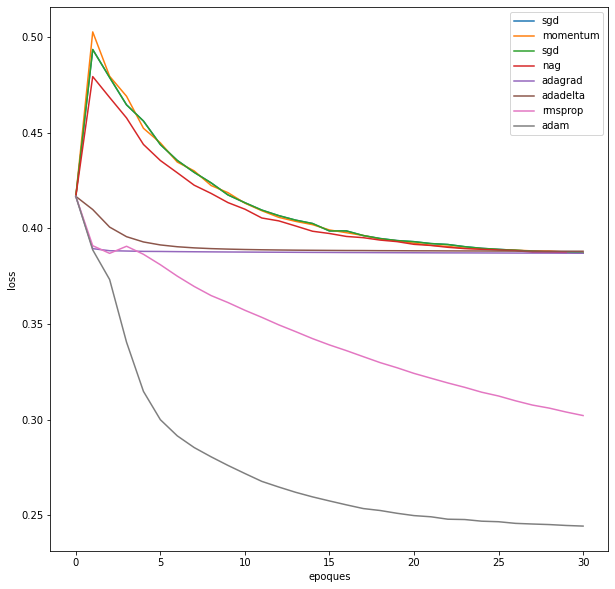

In [7]:
import matplotlib.pyplot as plt

plt.figure(1, figsize=(10,10))
plt.xlabel('epoques')
plt.ylabel('loss')

#affichage des progressions

data=pd.read_table("loss_sgd.txt", header=None)
y=data.values[:,0]
x=range(len(y))
plt.plot(x,y,label="sgd")

data=pd.read_table("loss_mom.txt", header=None)
y=data.values[:,0]
x=range(len(y))
plt.plot(x,y,label="momentum")

data=pd.read_table("loss_sgd.txt", header=None)
y=data.values[:,0]
x=range(len(y))
plt.plot(x,y,label="sgd")

data=pd.read_table("loss_nag.txt", header=None)
y=data.values[:,0]
x=range(len(y))
plt.plot(x,y,label="nag")

data=pd.read_table("loss_adagrad.txt", header=None)
y=data.values[:,0]
x=range(len(y))
plt.plot(x,y,label="adagrad")

data=pd.read_table("loss_adadelta.txt", header=None)
y=data.values[:,0]
x=range(len(y))
plt.plot(x,y,label="adadelta")

data=pd.read_table("loss_rmsprop.txt", header=None)
y=data.values[:,0]
x=range(len(y))
plt.plot(x,y,label="rmsprop")

data=pd.read_table("loss_adam.txt", header=None)
y=data.values[:,0]
x=range(len(y))
plt.plot(x,y,label="adam")

plt.legend()
plt.show()